In [1]:
import shap
shap.initjs()

In [2]:
import numpy as np
import pandas as pd
df=pd.read_csv('data_final.csv')
X=df.loc[:, ['Temperature', 'Addion_time', 'Mode','Reaction_time']]
X = (X-X.min())/(X.max()-X.min())
y= df.loc[:, [ 'Mn', 'PDI','Skewness','Kurtosis']]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1104)
kmeans=KMeans(n_clusters=5,random_state=50).fit(X_train)
centers = np.array(kmeans.cluster_centers_)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [4]:
data_index_new1=np.arange(0,453)
X_train.index=data_index_new1
y_train.index=data_index_new1

In [5]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(centers, X_train)

In [6]:
data_inital=pd.concat([X_train.iloc[closest,],y_train.iloc[closest,]],axis=1,join='outer')

In [7]:
X_train_init=data_inital.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
y_train_init=data_inital.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]

In [8]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import entropy_sampling
from xgboost import XGBRegressor

In [9]:
def list_by_models(X,y):
    sklearn_list = [Ridge(), Lasso(), LinearRegression(),XGBRegressor(),RandomForestRegressor(n_estimators =50),RandomForestRegressor(n_estimators =100),KNeighborsRegressor(n_neighbors=2, weights='distance')]
    learner_list=[]
    for regressor_emcm in sklearn_list:
        learner=ActiveLearner(estimator=regressor_emcm, query_strategy=max_std_sampling, X_training=X, y_training=y)
        learner_list.append(learner)
    print(len(X))
    return learner_list

In [10]:
from numpy.linalg import norm
def expected_model_change_maximization(regressor, learner_list, X_pool, n_instances=1):
    changes = []
    for x in X_pool:
        x = x.reshape(1, -1)
        change = 0
        x_norm = norm(x)
        y_hat = regressor.predict(x)[0]
        for learner in learner_list:
            y_p = learner.predict(x)[0]
            change += abs(y_hat - y_p) * x_norm
            #change += abs(y_hat - y_p)
        change /= len(learner_list)
        changes.append(change)
    changes=np.squeeze(changes)
    #print(changes)
    changes_sum=changes.sum(axis=1)
    #print(changes_sum)
    query_idx = changes_sum.argsort()[-n_instances:][::-1]
    return query_idx

In [11]:
X_train_beiyong=X_train
y_train_beiyong=y_train

In [12]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
# search_best_score_list=[]
# for j in range(1,150):
#     regressor=RandomForestRegressor(n_estimators=j,random_state=66)
#     regressor.fit(X_train_init, y_train_init)
#     test_score=regressor.score(X_test, y_test)
#     search_best_score_list.append(test_score)
# best_score_index=search_best_score_list.index(max(search_best_score_list))
# j_best=best_score_index+1
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
regressor.fit(X_train_init, y_train_init)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=66, ...)

In [13]:
data_final=data_inital#Inital data_final
test_score_list=[]
mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train.values, n_instances=1)
    data_relable=pd.concat([X_train.iloc[re_idx,],y_train.iloc[re_idx,]],axis=1,join='outer')
    X_train=X_train.drop(re_idx)
    y_train=y_train.drop(re_idx)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))
    r_error_all=(metrics.mean_absolute_error(y_predict,y_test))/np.mean(np.array(y_test))
    print('Related Error',r_error_all)

inital mse 48.61469767939108
453
5
Testing Score:-3.762223
Mean Squared Error: 38.69360257837092
Related Error 0.6368515460500329
452
6
Testing Score:-3.604515
Mean Squared Error: 39.094010980586916
Related Error 0.6390448797540026
451
7
Testing Score:-0.749310
Mean Squared Error: 39.77565986481498
Related Error 0.5214546790141585
450
8
Testing Score:-1.845157
Mean Squared Error: 38.3889907832439
Related Error 0.5920148415572268
449
9
Testing Score:-1.701084
Mean Squared Error: 30.25826529097253
Related Error 0.5634315058803718
448
10
Testing Score:-0.373406
Mean Squared Error: 25.39942852447818
Related Error 0.47177535191185094
447
11
Testing Score:-0.364787
Mean Squared Error: 14.418129240705381
Related Error 0.39377463530425566
446
12
Testing Score:-0.382551
Mean Squared Error: 12.267760286459662
Related Error 0.38504436668928216
445
13
Testing Score:-0.354144
Mean Squared Error: 12.119718896773676
Related Error 0.378967885708946
444
14
Testing Score:0.073799
Mean Squared Error: 9.4

In [14]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_relabel)

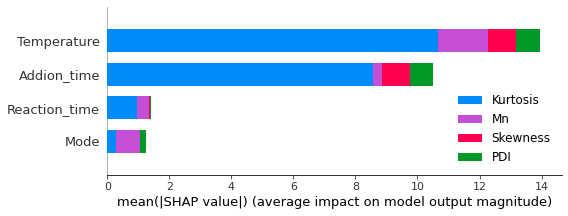

In [15]:
shap.summary_plot(shap_values, X_train_relabel, plot_type='bar', feature_names=['Temperature', 'Addion_time', 'Mode','Reaction_time'],class_names=[ 'Mn', 'PDI','Skewness','Kurtosis'])

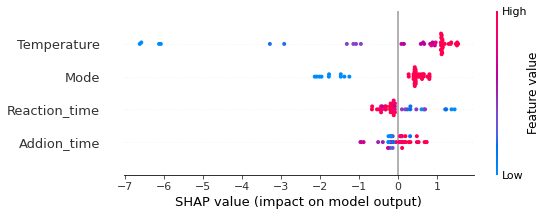

In [16]:
shap.summary_plot(shap_values[0], X_train_relabel)

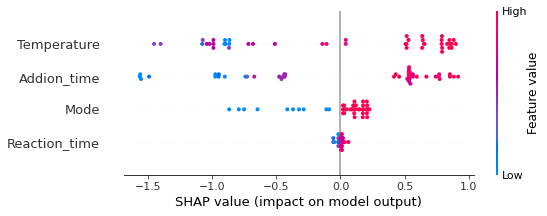

In [17]:
shap.summary_plot(shap_values[1], X_train_relabel)

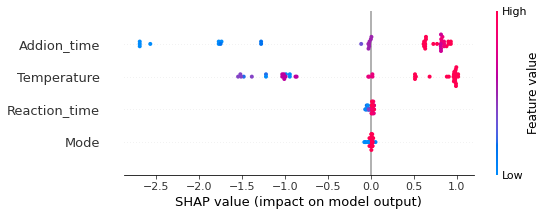

In [18]:
shap.summary_plot(shap_values[2], X_train_relabel)

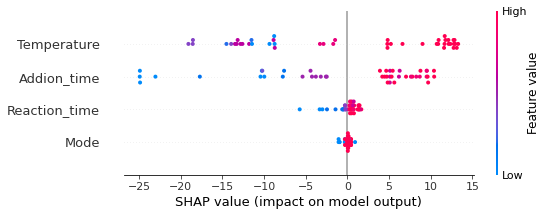

In [19]:
shap.summary_plot(shap_values[3], X_train_relabel)

In [20]:
shap_values_0= shap_values[0] 
shap_values_1= shap_values[1] 
shap_values_2= shap_values[2] 
shap_values_3= shap_values[3] 

In [21]:
explainer.expected_value

[14.11871, 4.258333, 4.154105, 21.000954]

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values_0[10,:], X_train_relabel.iloc[10,:])

In [23]:
shap.force_plot(explainer.expected_value[1], shap_values_1[10,:], X_train_relabel.iloc[10,:])

In [24]:
shap.force_plot(explainer.expected_value[2], shap_values_2[10,:], X_train_relabel.iloc[10,:])

In [25]:
shap.force_plot(explainer.expected_value[3], shap_values_3[10,:], X_train_relabel.iloc[10,:])